# Курсовой проект "Библиотеки Python для Data Science: продолжение"

## Содержание

### 1. Подключение библиотек

In [1]:
# 1. Основные библиотеки
import numpy as np
import pandas as pd
import random
import pickle   # сохранение модели

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

# 2. Разделение датасета
from sklearn.model_selection import train_test_split

# 3. Модели
import xgboost as xgb, lightgbm as lgbm, catboost as catb
from sklearn.model_selection import KFold, GridSearchCV, RandomizedSearchCV

# 4. Метрики
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score

from sklearn.preprocessing import StandardScaler

import warnings
warnings.filterwarnings('ignore')
matplotlib.rcParams.update({'font.size': 14})

# Дополнительные библиотеки
from datetime import datetime

### 2. Пути к директориям и файлам

In [2]:
TRAIN_DATASET_PATH = './course_project_train.csv'
TEST_DATASET_PATH = './course_project_test.csv'
PREPARED_DATASET_PATH = './prepared.csv'

# output
TRAIN_FULL_PATH = './course_project_train_full.csv'
TRAIN_PART_PATH = './course_project_train_part_b.csv'
TEST_PART_PATH = './course_project_test_part.csv'

SCALER_FILE_PATH = './scaler.pkl'

In [3]:
train_df = pd.read_csv(TRAIN_DATASET_PATH)
test_df = pd.read_csv(TEST_DATASET_PATH)

In [4]:
print('Строк в трейне:', train_df.shape[0])
print('Строк в тесте', test_df.shape[0])

Строк в трейне: 7500
Строк в тесте 2500


In [5]:
df = pd.read_csv(TRAIN_DATASET_PATH)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,99999999.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,99999999.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


### Описание датасета

* Home Ownership - домовладение
* Annual Income - годовой доход
* Years in current job - количество лет на текущем месте работы
* Tax Liens - налоговые обременения
* Number of Open Accounts - количество открытых счетов
* Years of Credit History - количество лет кредитной истории
* Maximum Open Credit - наибольший открытый кредит
* Number of Credit Problems - количество проблем с кредитом
* Months since last delinquent - количество месяцев с последней просрочки платежа
* Bankruptcies - банкротства
* Purpose - цель кредита
* Term - срок кредита
* Current Loan Amount - текущая сумма кредита
* Current Credit Balance - текущий кредитный баланс
* Monthly Debt - ежемесячный долг
* Credit Default - факт невыполнения кредитных обязательств (0 - погашен вовремя, 1 - просрочка)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 5943 non-null   float64
 2   Years in current job          7129 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  3419 non-null   float64
 9   Bankruptcies                  7486 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

Видно, что есть пропуски в Annual Income, Years in current job, Months since last delinquent, Bankruptcies, Credit Score.
Посмотрим наличие выбросов и обзор целевой переменной.

### Обзор целевой переменной

In [7]:
df['Credit Default'].value_counts()

0    5387
1    2113
Name: Credit Default, dtype: int64

### Обзор количественных признаков

In [8]:
# находим все количественные признаки
df_num_features = df.select_dtypes(include=['float64', 'int64'])

# Убираем из признаков целевую переменную
df_num_features.drop('Credit Default', axis=1, inplace=True)
df_num_features

,Annual Income,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score
0,482087.0,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,99999999.0,47386.0,7914.0,749.0
1,1025487.0,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,264968.0,394972.0,18373.0,737.0
2,751412.0,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,99999999.0,308389.0,13651.0,742.0
3,805068.0,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,121396.0,95855.0,11338.0,694.0
4,776264.0,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,125840.0,93309.0,7180.0,719.0
...,...,...,...,...,...,...,...,...,...,...,...,...
7495,402192.0,0.0,3.0,8.5,107866.0,0.0,NaN,0.0,129360.0,73492.0,1900.0,697.0
7496,1533984.0,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,444048.0,456399.0,12783.0,7410.0
7497,1878910.0,0.0,12.0,32.1,1778920.0,0.0,NaN,0.0,99999999.0,477812.0,12479.0,748.0
7498,NaN,0.0,21.0,26.5,1141250.0,0.0,NaN,0.0,615274.0,476064.0,37118.0,NaN


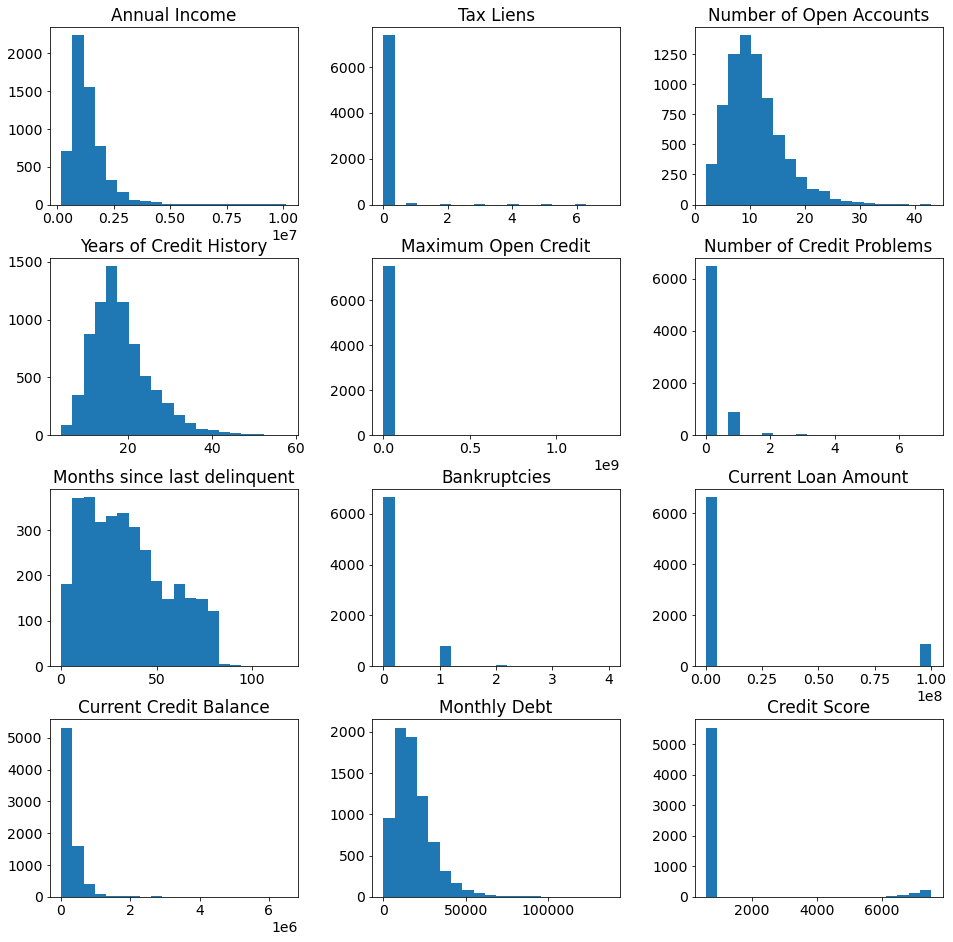

In [9]:
df_num_features.hist(figsize=(16,16), bins=20, grid=False);

 Наблюдаются выбросы в Annual Income, Maximum Open Credit, Current Loan Amount, Current Credit Balance, Credit Score.
 Разберемся подробнее

### Обработка выбросов у количественных переменных

In [10]:
df['Annual Income'].median()

1168386.0

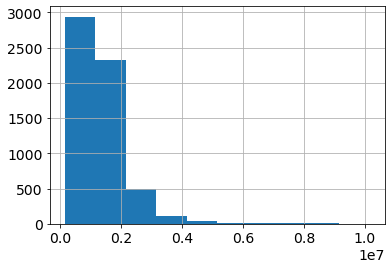

In [11]:
df['Annual Income'].hist();

Заменим значения для ежегодного дохода более 4 млн на 4 млн

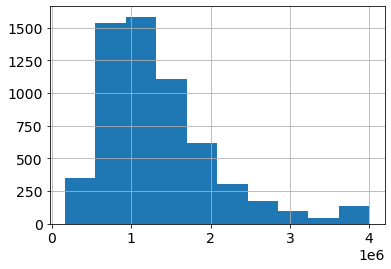

In [12]:
df.loc[(df['Annual Income'] > 4000000), 'Annual Income'] = 4000000
df['Annual Income'].hist();

In [13]:
df['Maximum Open Credit'].median()

478159.0

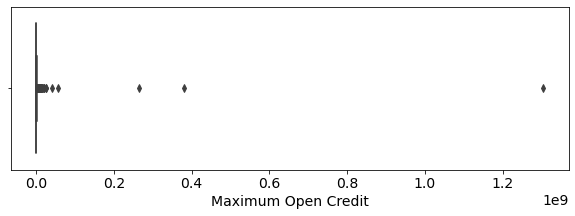

In [14]:
plt.figure(figsize=(10, 3))

sns.boxplot(df['Maximum Open Credit'], whis=1.5)

plt.xlabel('Maximum Open Credit')
plt.show()

Заменим значения для наибольшего открытого кредита более чем на 1.5 млн на 1.5 млн

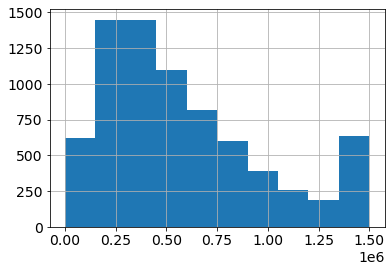

In [15]:
df.loc[(df['Maximum Open Credit'] > 1500000), 'Maximum Open Credit'] = 1500000
df['Maximum Open Credit'].hist();

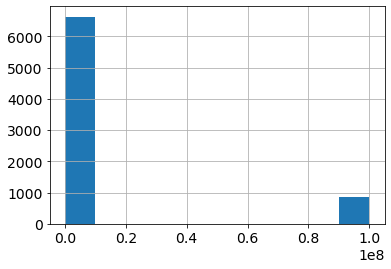

In [16]:
df['Current Loan Amount'].hist();

Заменим значения для текущей суммы кредита более чем на 1 млн на 1.5млн

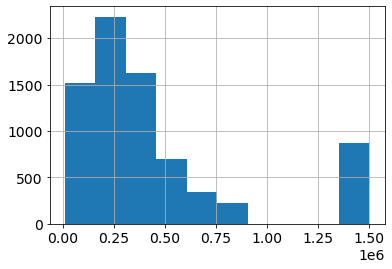

In [17]:
df.loc[(df['Current Loan Amount'] > 1500000), 'Current Loan Amount'] = 1500000
df['Current Loan Amount'].hist();

Найдем значения, где наибольший открытый кредит меньше текущей суммы кредита.

In [18]:
df.loc[(df["Current Loan Amount"] > df["Maximum Open Credit"])]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,685960.0,1.0,NaN,1.0,debt consolidation,Short Term,1500000.0,47386.0,7914.0,749.0,0
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1182434.0,0.0,NaN,0.0,debt consolidation,Short Term,1500000.0,308389.0,13651.0,742.0,0
6,Home Mortgage,1511108.0,10+ years,0.0,9.0,20.3,388124.0,0.0,73.0,0.0,home improvements,Short Term,1500000.0,51623.0,2317.0,745.0,0
8,Home Mortgage,NaN,5 years,0.0,17.0,15.7,0.0,1.0,NaN,1.0,home improvements,Short Term,129734.0,19.0,17.0,NaN,0
9,Home Mortgage,NaN,1 year,0.0,10.0,24.6,511302.0,0.0,6.0,0.0,debt consolidation,Long Term,572880.0,205333.0,17613.0,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7485,Rent,2687664.0,< 1 year,0.0,14.0,16.7,429154.0,0.0,77.0,0.0,debt consolidation,Short Term,466796.0,278711.0,44122.0,736.0,1
7487,Home Mortgage,1542952.0,10+ years,0.0,7.0,12.5,232364.0,0.0,59.0,0.0,debt consolidation,Long Term,267982.0,198873.0,15430.0,695.0,1
7488,Rent,465405.0,5 years,0.0,5.0,7.7,51744.0,0.0,33.0,0.0,home improvements,Short Term,129338.0,8721.0,13535.0,728.0,0
7491,Home Mortgage,2833185.0,6 years,0.0,18.0,21.3,280170.0,0.0,6.0,0.0,debt consolidation,Short Term,437404.0,108889.0,61150.0,704.0,0


Таких случаев очень много, значит заменим значения наибольшего открытого кредита на значения суммы текущего кредита.

In [19]:
df.loc[(df["Current Loan Amount"] > df["Maximum Open Credit"]), "Maximum Open Credit"] = df["Current Loan Amount"]

In [20]:
df.loc[(df["Credit Score"] > 1000)]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
69,Home Mortgage,1408527.0,2 years,0.0,12.0,17.5,700062.0,0.0,21.0,0.0,other,Long Term,525998.0,174135.0,9320.0,6470.0,1
87,Home Mortgage,1533566.0,7 years,0.0,11.0,14.8,715462.0,0.0,19.0,0.0,debt consolidation,Short Term,210826.0,285475.0,18147.0,7440.0,1
94,Rent,1049294.0,3 years,0.0,5.0,6.1,337502.0,0.0,NaN,0.0,business loan,Short Term,337502.0,119529.0,15215.0,7010.0,1
96,Rent,757568.0,5 years,0.0,13.0,11.4,383548.0,0.0,NaN,0.0,debt consolidation,Short Term,210518.0,276583.0,11553.0,7320.0,1
116,Home Mortgage,1039984.0,NaN,0.0,10.0,23.8,224246.0,0.0,63.0,0.0,debt consolidation,Short Term,224246.0,95456.0,13780.0,7390.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7422,Rent,694868.0,1 year,0.0,4.0,7.8,244178.0,0.0,NaN,0.0,debt consolidation,Long Term,244178.0,122075.0,4268.0,6690.0,1
7433,Rent,2011758.0,< 1 year,0.0,4.0,14.9,106480.0,0.0,43.0,0.0,buy a car,Long Term,106480.0,18791.0,12590.0,6060.0,1
7450,Home Mortgage,1432277.0,10+ years,0.0,16.0,22.8,825176.0,0.0,NaN,0.0,debt consolidation,Short Term,187924.0,458242.0,27094.0,7290.0,1
7460,Rent,769462.0,5 years,0.0,8.0,17.0,313786.0,0.0,80.0,0.0,debt consolidation,Short Term,109186.0,45524.0,4585.0,7470.0,1


In [21]:
df['Current Credit Balance'].median()

209323.0

In [22]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,NaN,0.0,11.0,26.3,1500000.0,1.0,NaN,1.0,debt consolidation,Short Term,1500000.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8 years,0.0,11.0,35.0,1500000.0,0.0,NaN,0.0,debt consolidation,Short Term,1500000.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6 years,0.0,8.0,22.5,147400.0,1.0,NaN,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8 years,0.0,13.0,13.6,385836.0,1.0,NaN,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


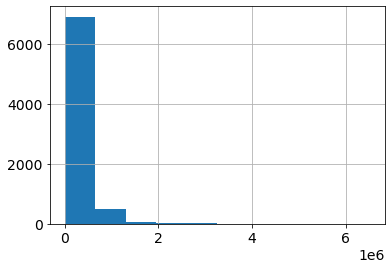

In [23]:
df['Current Credit Balance'].hist();

Заменим значения текущего кредитного баланса более 1.5 млн на 1.5 млн

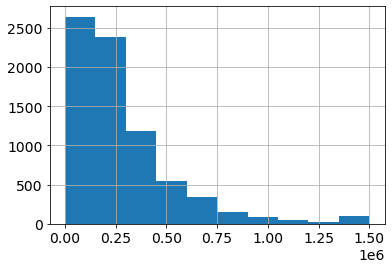

In [24]:
df.loc[(df['Current Credit Balance'] > 1500000), 'Current Credit Balance'] = 1500000
df['Current Credit Balance'].hist();

Найдем значения, где кредитный баланск больше суммы текущего кредита

In [25]:
df.loc[(df["Current Loan Amount"] < df["Current Credit Balance"])]

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
1,Own Home,1025487.0,10+ years,0.0,15.0,15.3,1181730.0,0.0,NaN,0.0,debt consolidation,Long Term,264968.0,394972.0,18373.0,737.0,1
13,Rent,2066364.0,10+ years,0.0,11.0,17.7,1500000.0,0.0,NaN,0.0,debt consolidation,Long Term,549780.0,1037077.0,21869.0,728.0,1
14,Own Home,2258796.0,7 years,0.0,11.0,17.7,1500000.0,0.0,NaN,0.0,other,Short Term,185262.0,1374327.0,58352.0,748.0,0
16,Rent,NaN,7 years,0.0,6.0,17.8,899492.0,0.0,NaN,0.0,debt consolidation,Long Term,313038.0,538346.0,18844.0,NaN,1
17,Home Mortgage,3361898.0,3 years,0.0,14.0,28.5,1042096.0,0.0,NaN,0.0,debt consolidation,Long Term,498872.0,689396.0,52249.0,644.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7479,Own Home,1721932.0,10+ years,0.0,9.0,28.0,912142.0,0.0,NaN,0.0,debt consolidation,Short Term,105490.0,723957.0,37022.0,739.0,0
7482,Home Mortgage,NaN,10+ years,0.0,14.0,30.5,645062.0,0.0,45.0,0.0,debt consolidation,Short Term,188430.0,518662.0,23506.0,NaN,0
7486,Rent,4000000.0,1 year,0.0,7.0,12.1,605638.0,0.0,NaN,0.0,debt consolidation,Short Term,111760.0,292904.0,8080.0,750.0,0
7496,Home Mortgage,1533984.0,1 year,0.0,10.0,26.5,686312.0,0.0,43.0,0.0,debt consolidation,Long Term,444048.0,456399.0,12783.0,7410.0,1


Заменим эти значения на сумму текущего кредита

In [26]:
df.loc[(df["Current Loan Amount"] < df["Current Credit Balance"]), "Current Credit Balance"] = df["Current Loan Amount"]

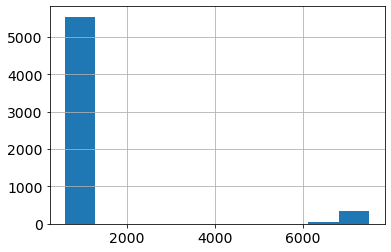

In [27]:
df['Credit Score'].hist();

### Обработка пропусков у количественных переменных

In [28]:
# Заполним пропуски для признаков Annual Income, Years in current job, Months since last delinquent, 
# Bankruptcies, Credit Score на моды
df.loc[df['Annual Income'].isna(), 'Annual Income'] = df['Annual Income'].mode()[0]
df.loc[df['Years in current job'].isna(), 'Years in current job'] = df['Years in current job'].mode()[0]
df.loc[df['Months since last delinquent'].isna(), 'Months since last delinquent'] = df['Months since last delinquent'].mode()[0]
df.loc[df['Bankruptcies'].isna(), 'Bankruptcies'] = df['Bankruptcies'].mode()[0]
df.loc[df['Credit Score'].isna(), 'Credit Score'] = df['Credit Score'].mode()[0]

In [29]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   object 
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

### Обзор категориальных переменных

In [30]:
df["Years in current job"].value_counts()

10+ years    2703
2 years       705
3 years       620
< 1 year      563
5 years       516
1 year        504
4 years       469
6 years       426
7 years       396
8 years       339
9 years       259
Name: Years in current job, dtype: int64

In [31]:
# Заменим значения Years in current job на числовые
df.loc[df["Years in current job"] == "< 1 year", "Years in current job"] = 0
df.loc[df["Years in current job"] == "1 year", "Years in current job"] = 1
df.loc[df["Years in current job"] == "2 years", "Years in current job"] = 2
df.loc[df["Years in current job"] == "3 years", "Years in current job"] = 3
df.loc[df["Years in current job"] == "4 years", "Years in current job"] = 4
df.loc[df["Years in current job"] == "5 years", "Years in current job"] = 5
df.loc[df["Years in current job"] == "6 years", "Years in current job"] = 6
df.loc[df["Years in current job"] == "7 years", "Years in current job"] = 7
df.loc[df["Years in current job"] == "8 years", "Years in current job"] = 8
df.loc[df["Years in current job"] == "9 years", "Years in current job"] = 9
df.loc[df["Years in current job"] == "10+ years", "Years in current job"] = 10

In [32]:
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,Purpose,Term,Current Loan Amount,Current Credit Balance,Monthly Debt,Credit Score,Credit Default
0,Own Home,482087.0,10,0.0,11.0,26.3,1500000.0,1.0,14.0,1.0,debt consolidation,Short Term,1500000.0,47386.0,7914.0,749.0,0
1,Own Home,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,14.0,0.0,debt consolidation,Long Term,264968.0,264968.0,18373.0,737.0,1
2,Home Mortgage,751412.0,8,0.0,11.0,35.0,1500000.0,0.0,14.0,0.0,debt consolidation,Short Term,1500000.0,308389.0,13651.0,742.0,0
3,Own Home,805068.0,6,0.0,8.0,22.5,147400.0,1.0,14.0,1.0,debt consolidation,Short Term,121396.0,95855.0,11338.0,694.0,0
4,Rent,776264.0,8,0.0,13.0,13.6,385836.0,1.0,14.0,0.0,debt consolidation,Short Term,125840.0,93309.0,7180.0,719.0,0


Изменим категориальную Years in current job переменную на количественную 

In [33]:
df.loc[df["Years in current job"], "Years in current job"] = df['Years in current job'].astype(str).astype(int)

In [34]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 17 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   int32  
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Purpose                       7500 non-null   object 
 11  Term                          7500 non-null   object 
 12  Current Loan Amount           7500 non-null   float64
 13  Cur

In [35]:
df["Purpose"].value_counts()

debt consolidation      5944
other                    665
home improvements        412
business loan            129
buy a car                 96
medical bills             71
major purchase            40
take a trip               37
buy house                 34
small business            26
wedding                   15
moving                    11
educational expenses      10
vacation                   8
renewable energy           2
Name: Purpose, dtype: int64

Добавим новых признаков на основе цели кредита

In [36]:
df = pd.concat([df, pd.get_dummies(df['Purpose'])], axis=1)
df.head()

,Home Ownership,Annual Income,Years in current job,Tax Liens,Number of Open Accounts,Years of Credit History,Maximum Open Credit,Number of Credit Problems,Months since last delinquent,Bankruptcies,...,home improvements,major purchase,medical bills,moving,other,renewable energy,small business,take a trip,vacation,wedding
0,Own Home,482087.0,10,0.0,11.0,26.3,1500000.0,1.0,14.0,1.0,...,0,0,0,0,0,0,0,0,0,0
1,Own Home,1025487.0,10,0.0,15.0,15.3,1181730.0,0.0,14.0,0.0,...,0,0,0,0,0,0,0,0,0,0
2,Home Mortgage,751412.0,8,0.0,11.0,35.0,1500000.0,0.0,14.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,Own Home,805068.0,6,0.0,8.0,22.5,147400.0,1.0,14.0,1.0,...,0,0,0,0,0,0,0,0,0,0
4,Rent,776264.0,8,0.0,13.0,13.6,385836.0,1.0,14.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [37]:
df.drop('Purpose', axis=1, inplace=True)

In [38]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 31 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   int32  
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Term                          7500 non-null   object 
 11  Current Loan Amount           7500 non-null   float64
 12  Current Credit Balance        7500 non-null   float64
 13  Mon

In [39]:
df["Term"].value_counts()

Short Term    5556
Long Term     1944
Name: Term, dtype: int64

Добавим новых признаков на основе Term

In [40]:
df = pd.concat([df, pd.get_dummies(df['Term'])], axis=1)

In [41]:
df.drop('Term', axis=1, inplace=True)

In [42]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7500 entries, 0 to 7499
Data columns (total 32 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Home Ownership                7500 non-null   object 
 1   Annual Income                 7500 non-null   float64
 2   Years in current job          7500 non-null   int32  
 3   Tax Liens                     7500 non-null   float64
 4   Number of Open Accounts       7500 non-null   float64
 5   Years of Credit History       7500 non-null   float64
 6   Maximum Open Credit           7500 non-null   float64
 7   Number of Credit Problems     7500 non-null   float64
 8   Months since last delinquent  7500 non-null   float64
 9   Bankruptcies                  7500 non-null   float64
 10  Current Loan Amount           7500 non-null   float64
 11  Current Credit Balance        7500 non-null   float64
 12  Monthly Debt                  7500 non-null   float64
 13  Cre

In [43]:
df = pd.concat([df, pd.get_dummies(df['Home Ownership'])], axis=1)
df.drop(['Home Ownership'], axis=1, inplace=True)

Теперь объединим всю выше описанную обработку в класс

In [44]:
class DataPreprocessor():
    
    def __init__(self):
        self.med_annual_income = None
        self.med_maximum_open_credit = None
        self.med_current_loan_amount = None
        self.med_current_credit_balance = None
               
    def fit(self, df):
        # Расчет медиан
        self.med_annual_income = df['Annual Income'].median()
        self.med_maximum_open_credit = df['Maximum Open Credit'].median()
        self.med_current_loan_amount = df['Current Loan Amount'].median()
        self.med_current_credit_balance = df['Current Credit Balance'].median()
        
    def transform(self, df):
        
        # обработка выбросов
        df.loc[(df['Annual Income'] > 4000000), 'Annual Income'] = 4000000
        df.loc[(df['Maximum Open Credit'] > 1500000), 'Maximum Open Credit'] = 1500000
        df.loc[(df['Current Loan Amount'] > 1500000), 'Current Loan Amount'] = 1500000
        df.loc[(df["Current Loan Amount"] > df["Maximum Open Credit"]), "Maximum Open Credit"] = df["Current Loan Amount"]
        df.loc[(df['Current Credit Balance'] > 1500000), 'Current Credit Balance'] = 1500000
        df.loc[(df["Current Loan Amount"] < df["Current Credit Balance"]), "Current Credit Balance"] = df["Current Loan Amount"]
        
        # Обработка пропусков
        df.loc[df['Annual Income'].isna(), 'Annual Income'] = df['Annual Income'].mode()[0]
        df.loc[df['Years in current job'].isna(), 'Years in current job'] = df['Years in current job'].mode()[0]
        df.loc[df['Months since last delinquent'].isna(), 'Months since last delinquent'] = df['Months since last delinquent'].mode()[0]
        df.loc[df['Bankruptcies'].isna(), 'Bankruptcies'] = df['Bankruptcies'].mode()[0]
        df.loc[df['Credit Score'].isna(), 'Credit Score'] = df['Credit Score'].mode()[0]
        
        # Обработка неправильных значений
        df.loc[df["Number of Open Accounts"] < 0, "Number of Open Accounts"] = 1

        # Обработка категорий
        df.loc[df["Years in current job"] == "< 1 year", "Years in current job"] = 0
        df.loc[df["Years in current job"] == "1 year", "Years in current job"] = 1
        df.loc[df["Years in current job"] == "2 years", "Years in current job"] = 2
        df.loc[df["Years in current job"] == "3 years", "Years in current job"] = 3
        df.loc[df["Years in current job"] == "4 years", "Years in current job"] = 4
        df.loc[df["Years in current job"] == "5 years", "Years in current job"] = 5
        df.loc[df["Years in current job"] == "6 years", "Years in current job"] = 6
        df.loc[df["Years in current job"] == "7 years", "Years in current job"] = 7
        df.loc[df["Years in current job"] == "8 years", "Years in current job"] = 8
        df.loc[df["Years in current job"] == "9 years", "Years in current job"] = 9
        df.loc[df["Years in current job"] == "10+ years", "Years in current job"] = 10
        df.loc[df["Years in current job"], "Years in current job"] = df['Years in current job'].astype(str).astype(int)
        df = pd.concat([df, pd.get_dummies(df['Purpose'])], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Term'])], axis=1)
        df = pd.concat([df, pd.get_dummies(df['Home Ownership'])], axis=1)
        
        # Удаляем ненужные признаки
        df.drop(['Purpose'], axis=1, inplace=True)
        df.drop(['Term'], axis=1, inplace=True)
        df.drop(['Home Ownership'], axis=1, inplace=True)

        return df

In [45]:
preprocessor = DataPreprocessor()
preprocessor.fit(train_df)
train_df = preprocessor.transform(train_df)
test_df = preprocessor.transform(test_df)

### Нормализация данных

In [46]:
TARGET_NAME = "Credit Default"
FEATURES_NAME = train_df.columns.drop(TARGET_NAME).tolist()
scaler = StandardScaler()

df_norm = train_df.copy()
df_norm[FEATURES_NAME] = scaler.fit_transform(df_norm[FEATURES_NAME])

df = df_norm.copy()

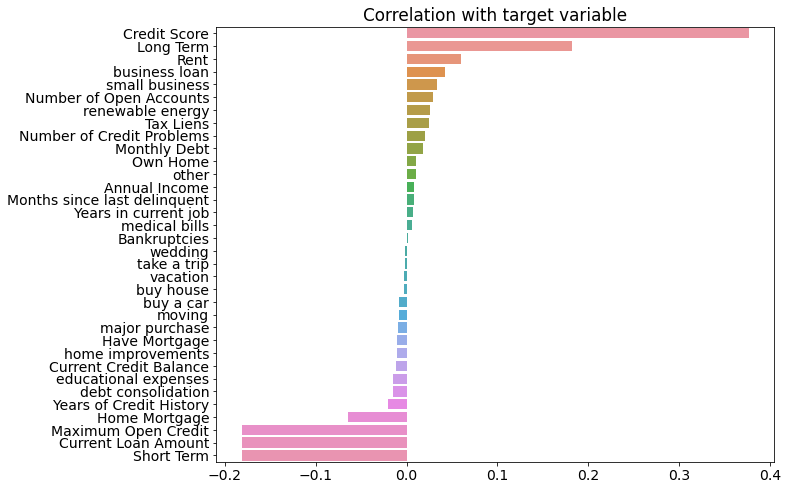

In [47]:
corr_with_target = df[FEATURES_NAME + [TARGET_NAME]].corr().iloc[:-1, -1].sort_values(ascending=False)

plt.figure(figsize=(10, 8))

sns.barplot(x=corr_with_target.values, y=corr_with_target.index)

plt.title('Correlation with target variable')
plt.show()

In [48]:
IMPORTANT_FEATURES = ["Long Term", "Short Term", "Current Loan Amount",
                     "Credit Score", "Rent", "Annual Income",
                     "business loan", "Home Mortgage", "small business",
                     "Years of Credit History", "Current Credit Balance", "Maximum Open Credit",
                     "Number of Open Accounts", "renewable energy", "Tax Liens",
                     "Number of Credit Problems", "Monthly Debt", "Own Home",
                     "buy a car", "moving", "major purchase", "Have Mortgage",
                     "home improvements", "educational expenses", "debt consolidation"]

### Сохранение модели для нормализации данных

In [49]:
with open(SCALER_FILE_PATH, 'wb') as file:
    pickle.dump(scaler, file)

### Разделение данных на тренировочную и тестовую последовательность

In [50]:
X = df[IMPORTANT_FEATURES]
y = df[TARGET_NAME]

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, test_size=0.30, random_state=21)

### Балансировка целевой переменной

In [51]:
def balance_df_by_target(df, target_name):

    target_counts = df[target_name].value_counts()

    major_class_name = target_counts.argmax()
    minor_class_name = target_counts.argmin()

    disbalance_coeff = int(target_counts[major_class_name] / target_counts[minor_class_name]) - 1

    for i in range(disbalance_coeff):
        sample = df[df[target_name] == minor_class_name].sample(target_counts[minor_class_name])
        df = df.append(sample, ignore_index=True)

    return df.sample(frac=1) 

In [52]:
df_for_balancing = pd.concat([X_train, y_train], axis=1)
df_balanced = balance_df_by_target(df_for_balancing, "Credit Default")
df_balanced[TARGET_NAME].value_counts()  

0    3771
1    2958
Name: Credit Default, dtype: int64

In [53]:
X_train = df_balanced.drop(columns=TARGET_NAME)
y_train = df_balanced[TARGET_NAME]

### Сохранение обучающего и тестового датасетов

In [54]:
train = pd.concat([X_train, y_train], axis=1)
test = pd.concat([X_test, y_test], axis=1)

In [55]:
df.to_csv(TRAIN_FULL_PATH, index=False, encoding='utf-8')
train.to_csv(TRAIN_PART_PATH, index=False, encoding='utf-8')
test.to_csv(TEST_PART_PATH, index=False, encoding='utf-8')

### Построение и оценка базовых моделей

In [56]:
def get_classification_report(y_train_true, y_train_pred, y_test_true, y_test_pred):
    print('TRAIN\n\n' + classification_report(y_train_true, y_train_pred))
    print('TEST\n\n' + classification_report(y_test_true, y_test_pred))
    print('CONFUSION MATRIX\n')
    print(pd.crosstab(y_test_true, y_test_pred))

XGBoost

In [57]:
# Бустинговые алгоритмы

model_xgb = xgb.XGBClassifier(random_state=21)
model_xgb.fit(X_train, y_train)

y_train_pred = model_xgb.predict(X_train)
y_test_pred = model_xgb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

[17:28:21] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.5.1/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
TRAIN

              precision    recall  f1-score   support

           0       0.97      0.98      0.98      3771
           1       0.98      0.96      0.97      2958

    accuracy                           0.97      6729
   macro avg       0.97      0.97      0.97      6729
weighted avg       0.97      0.97      0.97      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1616
           1       0.54      0.46      0.49       634

    accuracy                           0.74      2250
   macro avg       0.67      0.65      0.66      2250
weighted avg       0.72      0.74      0.73      2250

CONFUSION MATRIX

col_0

LightGBM

In [58]:
model_lgbm = lgbm.LGBMClassifier(random_state=21)
model_lgbm.fit(X_train, y_train)

y_train_pred = model_lgbm.predict(X_train)
y_test_pred = model_lgbm.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.90      0.96      0.93      3771
           1       0.94      0.87      0.90      2958

    accuracy                           0.92      6729
   macro avg       0.92      0.91      0.92      6729
weighted avg       0.92      0.92      0.92      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.83      0.81      1616
           1       0.52      0.47      0.49       634

    accuracy                           0.73      2250
   macro avg       0.66      0.65      0.65      2250
weighted avg       0.72      0.73      0.72      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1340  276
1                335  299


CatBoost

In [59]:
model_catb = catb.CatBoostClassifier(silent=True, random_state=21)
model_catb.fit(X_train, y_train)

y_train_pred = model_catb.predict(X_train)
y_test_pred = model_catb.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.88      0.95      0.91      3771
           1       0.93      0.83      0.88      2958

    accuracy                           0.90      6729
   macro avg       0.91      0.89      0.90      6729
weighted avg       0.90      0.90      0.90      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.85      0.82      1616
           1       0.54      0.46      0.50       634

    accuracy                           0.74      2250
   macro avg       0.67      0.65      0.66      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1373  243
1                344  290


### Выбор лучшей модели и подбор гиперпараметров

**Подбор гиперпараметров**

In [60]:
model_catb = catb.CatBoostClassifier(class_weights=[1, 3.5], silent=True, random_state=21)
params = {'n_estimators':[50, 100, 200, 500, 700, 1000, 1200, 1500],
          'max_depth':[3, 5, 7]}

In [61]:
cv=KFold(n_splits=3, random_state=21, shuffle=True)

In [62]:
%%time

rs = RandomizedSearchCV(model_catb, params, scoring='f1', cv=cv, n_jobs=-1)
rs.fit(X, y)

Wall time: 47 s


RandomizedSearchCV(cv=KFold(n_splits=3, random_state=21, shuffle=True),
                   estimator=<catboost.core.CatBoostClassifier object at 0x000001D5F832B850>,
                   n_jobs=-1,
                   param_distributions={'max_depth': [3, 5, 7],
                                        'n_estimators': [50, 100, 200, 500, 700,
                                                         1000, 1200, 1500]},
                   scoring='f1')

In [63]:
rs.best_params_

{'n_estimators': 1200, 'max_depth': 5}

In [64]:
rs.best_score_

0.5396608967694735

In [65]:
%%time

final_model = catb.CatBoostClassifier(n_estimators=1200, max_depth=5,
                                      silent=True, random_state=21)
final_model.fit(X_train, y_train)

y_train_pred = final_model.predict(X_train)
y_test_pred = final_model.predict(X_test)

get_classification_report(y_train, y_train_pred, y_test, y_test_pred)

TRAIN

              precision    recall  f1-score   support

           0       0.83      0.93      0.88      3771
           1       0.90      0.76      0.82      2958

    accuracy                           0.86      6729
   macro avg       0.86      0.85      0.85      6729
weighted avg       0.86      0.86      0.85      6729

TEST

              precision    recall  f1-score   support

           0       0.80      0.84      0.82      1616
           1       0.53      0.47      0.50       634

    accuracy                           0.74      2250
   macro avg       0.67      0.65      0.66      2250
weighted avg       0.73      0.74      0.73      2250

CONFUSION MATRIX

col_0              0    1
Credit Default           
0               1359  257
1                339  295
Wall time: 4.37 s
